# Imports

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
from datetime import datetime
from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score

plt.style.use('seaborn-darkgrid')

In [95]:
data_df = pd.read_csv(f'Worldometer-data-preprocessed/table_18-04-2022_preprocessed.csv')
data_df.head()

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious,Total Tests,Population,continent,Density
0,China,185035.0,2742.0,4641.0,3.0,151407.0,1637.0,28987.0,71.0,160000000.0,1.439324e+09,Asia,149.2199
1,USA,82383494.0,26881.0,1015821.0,109.0,80244093.0,41383.0,1123580.0,1438.0,996639125.0,3.344853e+08,North America,36.0000
2,India,43045527.0,1247.0,521996.0,31.0,42511701.0,928.0,11830.0,698.0,832104846.0,1.404347e+09,Asia,427.8611
3,Brazil,30261088.0,8470.0,662076.0,65.0,29262483.0,35432.0,336529.0,8318.0,63776166.0,2.152705e+08,South America,25.2888
4,France,27790834.0,19810.0,144205.0,48.0,25132351.0,217445.0,2514278.0,1541.0,260504402.0,6.553266e+07,Europe,118.8782


- Lưu dữ liệu 1 tuần vào `week_df`, dùng sau

In [96]:
week_df = pd.read_csv(f'Worldometer-data-preprocessed/data_1_week.csv')

- Coi thử mỗi lục địa có bao nhiêu nước

In [97]:
data_df.groupby('continent').size()

continent
Africa               58
Asia                 49
Australia/Oceania    18
Europe               48
North America        39
South America        14
dtype: int64

# Trực quan các mối quan hệ giữa các trường dữ liệu

## 1. Một trường đơn

### a) Total Cases

- Ta sẽ gom nhóm theo 6 châu lục, mỗi châu lục sẽ tính tổng `Total Cases`. Vì vậy ta chọn biểu đồ bar chart để so sánh `Total Cases` giữa các châu

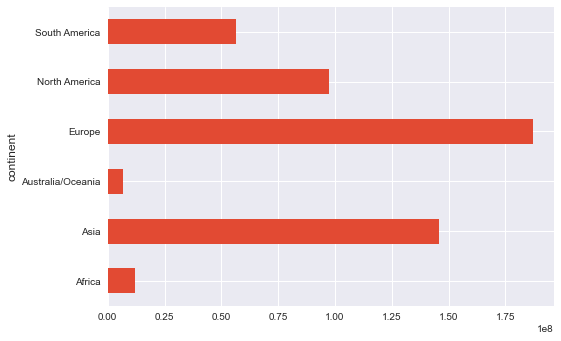

In [98]:
tcdf = data_df.groupby('continent')[['Total Cases', 'Population']].sum()
# tcdf['Total Cases'] = tcdf['Total Cases']/tcdf['Population']
tcdf['Total Cases'].plot.barh();

Nhận xét: tổng số ca nhiễm ở châu Âu và châu Á là nhiều nhất so với các châu lục còn lại. Điều này khá dễ hiểu vì châu Á có Trung Quốc là nơi đầu tiên bùng phát dịch bệnh; còn châu Âu thì đa phần người dân không đeo khẩu trang 

### b) Total Deaths

- Đầu tiên, ta gom nhóm theo 2 thuộc tính `continent` & `day`, sau đó lấy tổng trên thuộc tính `Total Deaths` để cho biết với mỗi châu lục vào mỗi ngày từ 18-25/4/2022 thì tổng số người chết là bao nhiêu

In [99]:
df = week_df.groupby(['continent', 'day'])[['Total Deaths']].sum()
df = df.reset_index()
df.head()

,continent,day,Total Deaths
0,Africa,18-04-2022,253519.0
1,Africa,19-04-2022,253559.0
2,Africa,20-04-2022,253596.0
3,Africa,21-04-2022,253667.0
4,Africa,22-04-2022,253681.0


- Vì tính chất dữ liệu theo thời gian nên ta dùng biểu đồ line chart để thể hiện sự thay đổi tổng số người chết - `Total Deaths` trong 1 tuần từ 18-25/4/2022
- Biểu đồ đầu tiên là biểu đồ tổng quát về sự biến thiên `Total Deaths` cho cả 6 châu lục 
- 6 biểu đồ còn lại là chi tiết biến thiên `Total Deaths` của từng châu lục

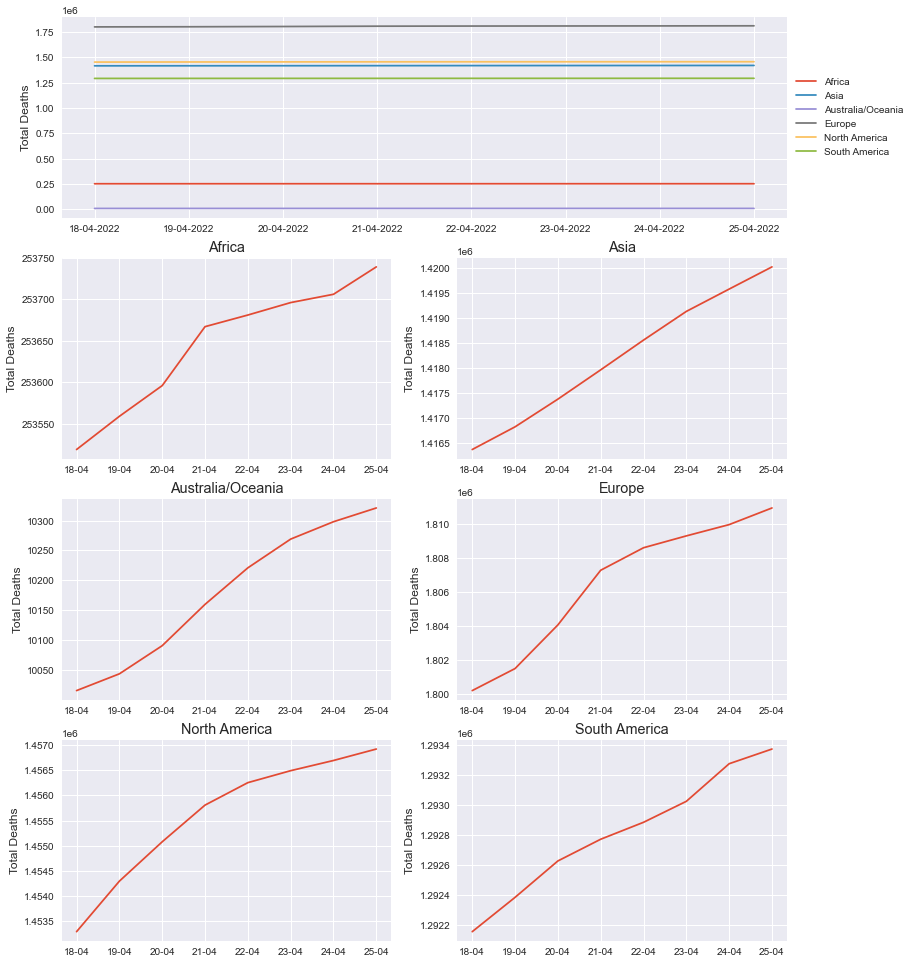

In [100]:
plt.figure(figsize=(13, 17))

ax = plt.subplot(4,2,(1,2))
sns.lineplot(data=df, x='day', y='Total Deaths', hue='continent', ax=ax);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel('')

for i, continent in enumerate(df['continent'].unique(), 3):
    continent_df = df.loc[df['continent'] == continent, 'Total Deaths']
    ax = plt.subplot(4,2,i)

    continent_df = df.loc[df['continent'] == continent, ['day', 'Total Deaths']].set_index('day')
    continent_df.plot.line(ax=ax, legend=None, title=continent, ylabel='Total Deaths', xlabel='')
    # rút gọn xtick từ dd-mm-yyy về dd-mm
    xticks = ax.get_xticks() # [-1, 0, 1,...]
    trunc_labels = [d[0:5] for d in continent_df.index]
    # thay đổi xticks labels
    ax.set_xticks(xticks[1:-1])
    ax.set_xticklabels(trunc_labels)

Nhận xét: 
- Với biểu đồ đầu tiên: Nhận thấy rằng 1 tuần vừa qua, số người chết hầu như không đổi ở 6 châu lục, ta sẽ xét cụ thể từng châu lục trong các biểu đồ dưới. Ngoài ra, dễ thấy tổng số ca chết tập trung cao ở 4 châu (giảm dần): Europe, North America, Asia và South America và tập trung thấp ở 2 châu còn lại: Africa & Australia/Oceania
- Qua các biểu đồ còn lại, thấy rằng thuộc tính `Total Deaths` có xu hướng tăng qua từng ngày bất kể châu lục nào, ví dụ Africa số ca chết tăng 200 người so với đầu tuần, Asia tăng khoảng 10000 ca chết so với đầu tuần, ...

### c) New Cases, New Deaths, New Recovered
- Ta sẽ xem xét riêng lẻ 3 cột này trong 1 tuần, từ 18/4/2022 - 25/4/2022

In [101]:
# data 18-04
df = data_df.groupby('continent')[['New Cases', 'New Deaths', 'New Recovered']].sum().reset_index()
df['day'] = 18

# data 25-04
df_25 = pd.read_csv(f'Worldometer-data-preprocessed/table_25-04-2022_preprocessed.csv')
df_25 = df_25.groupby('continent')[['New Cases', 'New Deaths', 'New Recovered']].sum().reset_index()
df_25['day'] = 25

df = pd.concat([df, df_25], axis=0)
df.head()

,continent,New Cases,New Deaths,New Recovered,day
0,Africa,1139.0,39.0,820.0,18
1,Asia,147568.0,490.0,128362.0,18
2,Australia/Oceania,40610.0,19.0,56266.0,18
3,Europe,120322.0,693.0,730283.0,18
4,North America,35540.0,143.0,49775.0,18


#### Góc nhìn từ slope graph: 
Ta mong muốn có 1 cái nhìn trực tiếp về tốc độ phát sinh các ca nhiễm mới (`New Deaths`)/ ca chết mới (`New Deaths`)/ ca hồi phục mới (`New Recovered`) theo thời gian. Đây là 1 thể loại con của line graph 

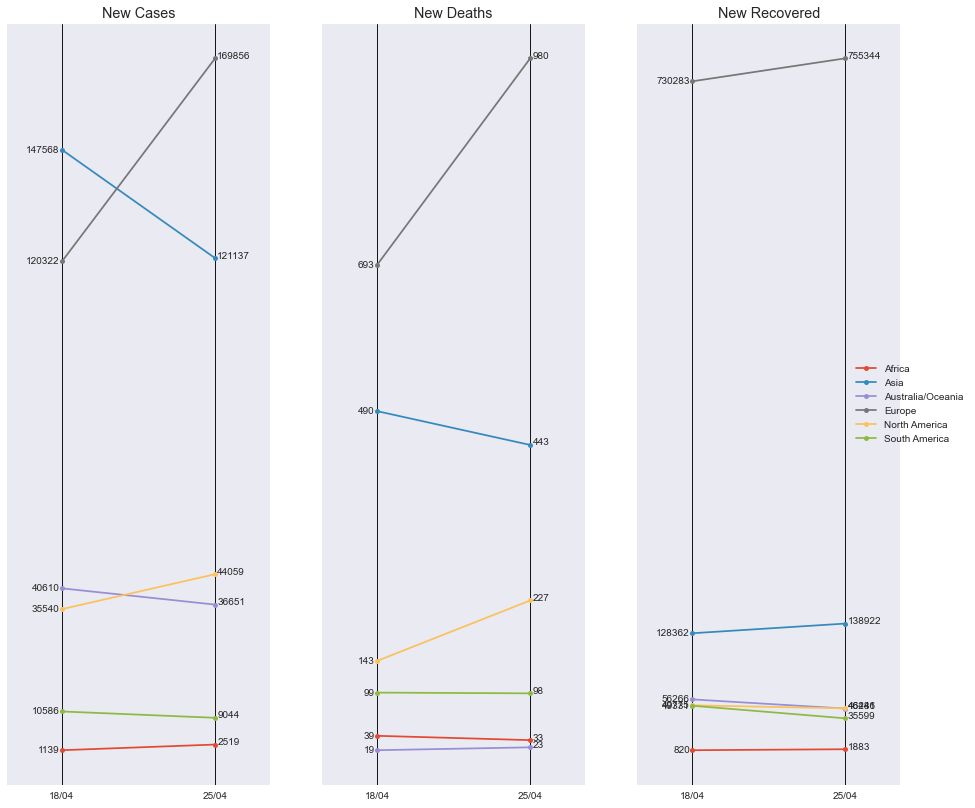

In [102]:
cols = ['New Cases', 'New Deaths', 'New Recovered']
continents = df['continent'].unique()
plt.figure(figsize=(16, 14))

for i, col in enumerate(cols, 1):
    ax = plt.subplot(1,3,i)
    for continent in continents:
        temp = df[df['continent'] == continent]
        plt.plot(temp['day'], temp[col], marker='o', markersize=5)
        plt.text(temp['day'].values[1]+0.1, temp[col].values[1], int(temp[col].values[1]))
        plt.text(temp['day'].values[0]-0.1, temp[col].values[0], int(temp[col].values[0]), va='center', ha='right')

    # x limits, x ticks
    plt.xlim(15.5, 27.5)
    plt.xticks([18, 25], ['18/04', '25/04'])

    # get y ticks, replace 1,000 with k, and draw the ticks
    yticks = plt.yticks()[0]
    plt.yticks([])

    # title
    plt.title(col)

    # grid
    ax.xaxis.grid(color='black', linestyle='solid', which='both', alpha=0.9)

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if i==3:
        plt.legend(continents, loc='center left', bbox_to_anchor=(0.8, 0.5));

Nhận xét: 
- `New Cases`: thuộc tính này có tốc độ thay đổi diễn ra mạnh hơn 2 thuộc tính còn lại. Europe trong 1 tuần tăng khoảng 49000 ca nhiễm mới, tốc độ lây lan nhanh nhất so với các châu còn lại, kế tiếp là North America. Asia và Australia/Ocenia là 2 châu lục giảm mạnh trong tuần, tuy vậy nhưng Asia vẫn xếp thứ 2 về số lượng lượng ca nhiễm mới. Còn Africa và South America lần lượt tăng và giảm 1 lượng không nhiều 
- `New Deaths`: tương tự thì Europe và Asia lần lượt là 2 châu lục tăng và giảm nhanh so với các châu còn lại, nhưng vẫn xếp hạng có `New Deaths` cao. North America tăng hơn 100 ca chết trong 1 tuần. Các châu lục còn lại chết dưới 10 người trong tuần qua
- `New Recovered`: thuộc tính này nhìn chung tốc độ tăng rất chậm, đôi khi là giảm. Dễ thấy tuy Europe có số ca nhiễm & ca chết tăng mạnh, nhưng tốc độ hồi phục cũng rất nhanh

#### Góc nhìn từ area plot:
Slope graph cho ta biết về tốc độ thay đổi của 3 cột `New Cases`, `New Deaths`, `New Recovered`. Ngoài ra ta còn muốn biết sự thay đổi này đáng kể hay không đáng kể so với tổng thể chung, chính vì vậy mà area chart được dùng

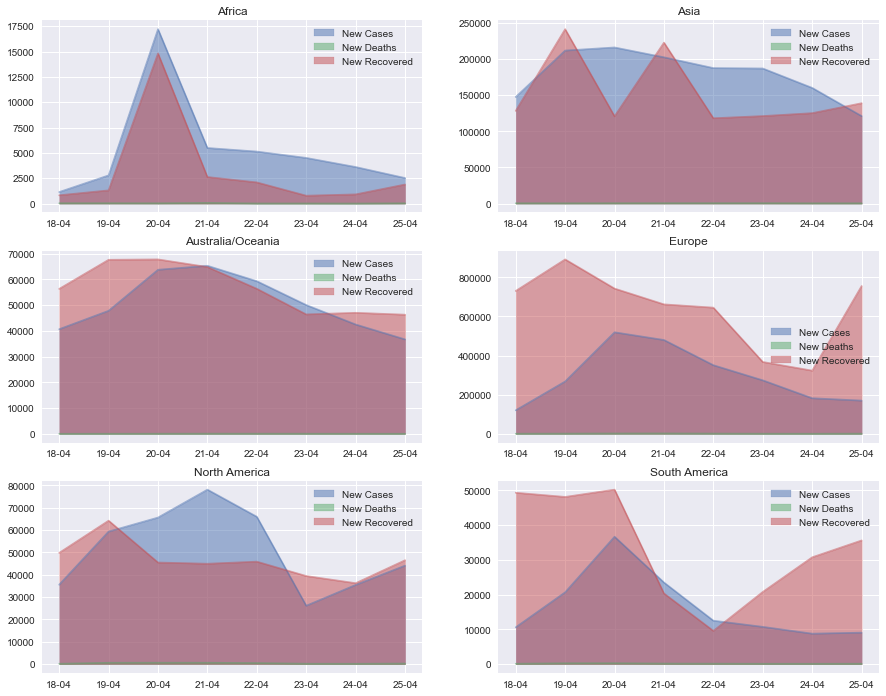

In [103]:
plt.style.use('seaborn')
df = week_df.groupby(['continent', 'day'])[['New Cases', 'New Deaths', 'New Recovered']].agg(sum).reset_index()

for i, continent in enumerate(df['continent'].unique(), 1):
    ax = plt.subplot(3,2,i)
    df_continent = df[df['continent'] == continent].drop(columns=['continent'])
    df_continent['day'] = df_continent['day'].apply(lambda x: x[:5])
    df_continent.set_index('day', inplace=True)
    df_continent.plot.area(stacked=False, ax=ax, figsize=(15,12), title=continent, xlabel='');

Nhận xét: 
- Tổng số người chết - `New Deaths` trên cả thể giới (6 châu lục) thay đổi rất nhỏ so với lượng `New Cases` & `New Recovered`
- Chiếm phần nhiều nhất hầu như là `New Recovered`, tuy tốc độ hồi phục theo như slope graph là chậm, nhưng số lượng người hồi phục thì rất nhiều, và nhiều hơn `New Cases`
- 1 điểm nhỏ nổi bật ở Asia: ngày 19 và 21/4/2022 là 2 ngày châu Á đạt 2 đỉnh

### d) Active Cases

- Ta so sánh `Active Cases` của mỗi châu lục thay đổi thế nào sau 1 tuần, vì vậy nên pie chart được dùng  

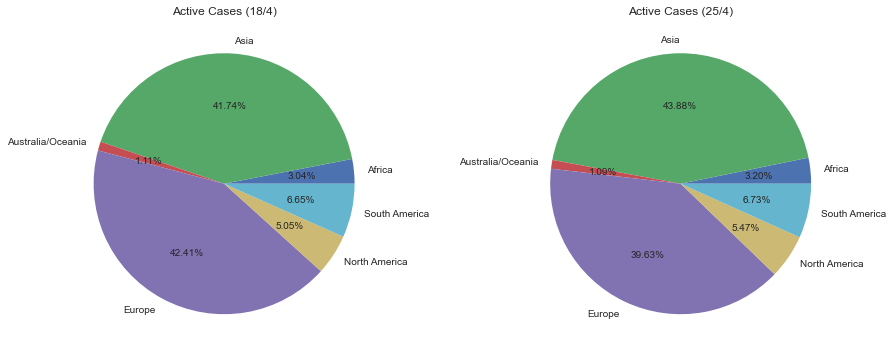

In [104]:
df = data_df.groupby('continent')[['Active Cases']].sum().rename(columns={'Active Cases': 'Active Cases (18/4)'})
df_25 = pd.read_csv(f'Worldometer-data-preprocessed/table_25-04-2022_preprocessed.csv')
df['Active Cases (25/4)'] = df_25.groupby('continent')[['Active Cases']].sum()['Active Cases']

ax = plt.subplot(1,2,1)
df.plot(kind='pie', y='Active Cases (18/4)', autopct='%.02f%%', figsize=(15, 6), ylabel='', legend='', ax=ax,
        title='Active Cases (18/4)')

ax = plt.subplot(1,2,2)
df.plot(kind='pie', y='Active Cases (25/4)', autopct='%.02f%%', figsize=(15, 6), ylabel='', legend='', ax=ax,
        title='Active Cases (25/4)');

Nhận xét: `Active Cases` trong 1 tuần của các châu lục tăng, trừ Europe & Australia/Oceania giảm

### e) New Deaths

In [105]:
world_df = week_df.groupby(['day'])['New Deaths'].agg(sum)
world_df = world_df.reset_index()
world_new_death_mean = world_df['New Deaths'].mean()
world_df['Status'] = world_df['New Deaths'].apply(lambda x: 'Extreme' if x > world_new_death_mean else 'Normal')
world_df.head()

,day,New Deaths,Status
0,18-04-2022,1483.0,Normal
1,19-04-2022,2461.0,Extreme
2,20-04-2022,3324.0,Extreme
3,21-04-2022,3513.0,Extreme
4,22-04-2022,2551.0,Extreme


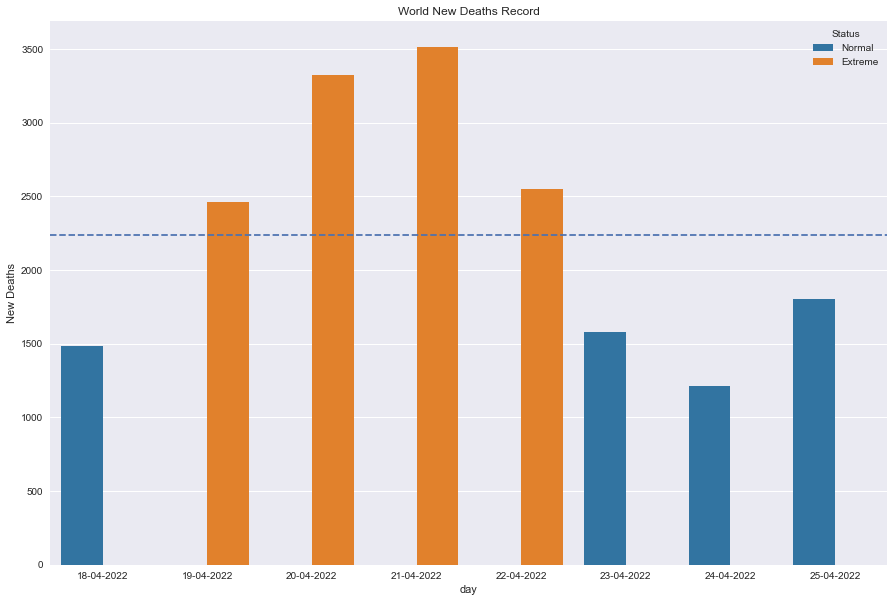

In [106]:
plt.figure(figsize=(15, 10))

sns.barplot(x='day', y='New Deaths', data=world_df, hue='Status', palette='tab10')
plt.axhline(world_new_death_mean,ls='--');
plt.title('World New Deaths Record');

Chọn biểu đồ cột vì đây là biểu đồ đơn giản để so sánh dữ liệu trong 1 khoảng thời gian ngắn. Có thể lấy số liệu của 1 tuần để có thể thể hiện rõ ràng hơn sự biến đổi dữ liệu trong 1 khoảng thời gian.

Nhận xét: Trong 3 ngày 19/04/2022 $\to$ 21/04/2022, số lượng ca tử vong mới tăng nhiều hơn hẳn các ngày còn lại. Ta sẽ tiến hành xem kỹ hơn số liệu của 3 ngày này.

In [107]:
df = week_df.groupby(['continent', 'day'])['New Deaths'].agg(sum)
df = df.reset_index()
df = df[df['day'].isin(['19-04-2022', '20-04-2022', '21-04-2022'])]
df.head()

,continent,day,New Deaths
1,Africa,19-04-2022,40.0
2,Africa,20-04-2022,32.0
3,Africa,21-04-2022,71.0
9,Asia,19-04-2022,453.0
10,Asia,20-04-2022,553.0


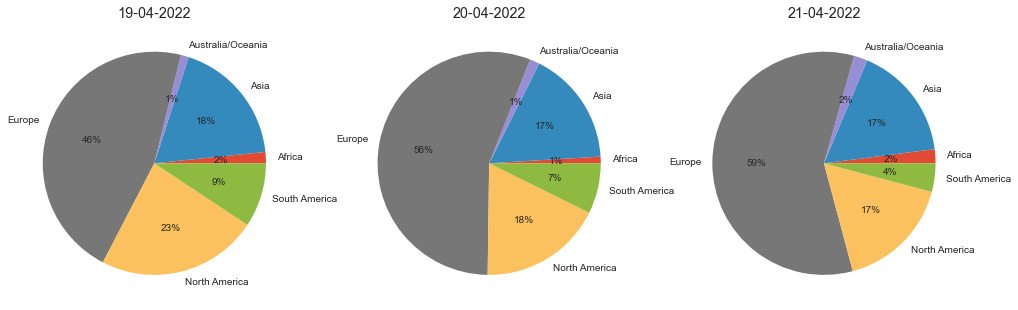

In [108]:
plt.figure(figsize=(17, 15))
plt.style.use('ggplot')

for i, d in enumerate(['19-04-2022', '20-04-2022', '21-04-2022'], 1):
    plt.subplot(1, 3, i)

    new_df = df[df['day'] == d]
    plt.pie(x=new_df['New Deaths'], labels=new_df['continent'], autopct='%.0f%%');
    plt.title(d)

Sử dụng biểu đồ pie chart vì đây là dạng biểu đồ dùng để thể hiện phần trăm của từng thành phần cấu tạo nên 1 quần thể. Từ đó chúng ta có thể dễ dàng so sánh sự đóng góp vào quần thể của từng thành phần.

Nhận xét: Trong cả 3 ngày 19, 20, 21/04/2022 thì **Europe** đều có số lượng ca tử vong mới cao nhất, tiếp đó là **North America** và **Asia** là 3 châu lục có số lượng ca tử vong mới cao nhất trên toàn thế giới.

## 2. Nhiều trường

### Total Deaths ~ Total Recovered

In [109]:
df = data_df[['Country', 'Total Recovered', 'Total Deaths']].set_index('Country')
# df.sort_values('Total Deaths', inplace=True)
df.head()

,Total Recovered,Total Deaths
Country,,
China,151407.0,4641.0
USA,80244093.0,1015821.0
India,42511701.0,521996.0
Brazil,29262483.0,662076.0
France,25132351.0,144205.0


#### Góc nhìn từ bidirectional bar chart

- Vì `Total Deaths` và `Total Recovered` là 2 thái cực trái nhau nên nhóm quyết định dùng **bidirectional bar chart** để thể hiện mối quan hệ giữa 2 trường này, với 30 nước đầu tiên được xếp theo thứ tự tăng dần của `Total Deaths`

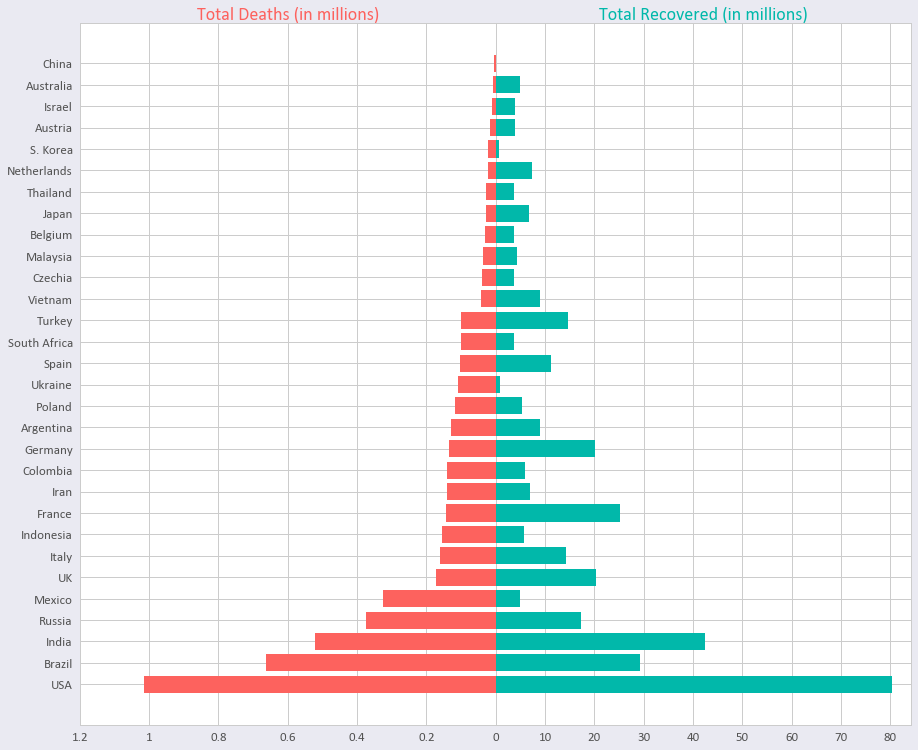

In [110]:
plt.style.use('seaborn-whitegrid') # fast
_df = df.iloc[:30].sort_values('Total Deaths')
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = _df.index
fig, axes = plt.subplots(figsize=(15,13), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout() #adjusts subplot params so that subplots are nicely fit in the figure.

axes[0].barh(index, _df['Total Deaths'], align='center', color=color_red, zorder=10)
axes[0].set_title('Total Deaths (in millions)', fontsize=18, pad=2, color=color_red, **hfont)
axes[1].barh(index, _df['Total Recovered'], align='center', color=color_blue, zorder=10)
axes[1].set_title('Total Recovered (in millions)', fontsize=18, pad=2, color=color_blue, **hfont)
axes[0].invert_xaxis()
plt.gca().invert_yaxis()

axes[0].set(yticks=index, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='white') # tick color

# thay đổi xticks labels
axes[1].set_xticks(np.array([10, 20, 30, 40, 50, 60, 70, 80])*1e6)
axes[1].yaxis.set_tick_params(size=0)
axes[1].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80])

# thay đổi xticks labels
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)    

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95) #wspace=0 for no gap between the two axes

Nhận xét: Các nước được xếp theo thứ tự tăng dần `Total Deaths`. Nhìn chung `Total Deaths` tăng thì `Total Recovered` nhiều khả năng cũng tăng theo, tuy nhiên mối quan hệ này không quá mạnh (ta có thể kiểm chứng bằng biểu đồ scatter phía dưới). Ngoài ra thì tỉ lệ Recovered luôn cao gấp hơn 10 lần so với tỉ lệ Deaths (Ví dự ở nước USA thì `Total Recovered` cao gấp 80 lần so với `Total Deaths`)

#### Góc nhìn từ scatter plot

- Mục đích là để kiểm chứng lại xem mối tương quan giữa `Total Deaths` & `Total Recovered` có phải tương quan dương và nếu có thì tương quan này mạnh hay yếu

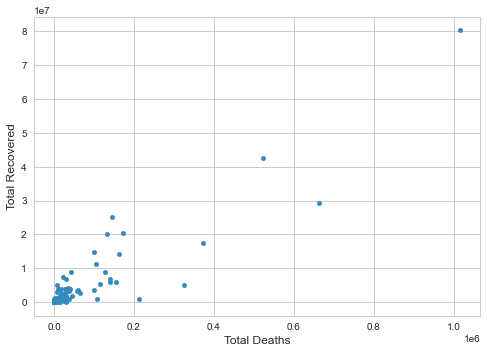

In [111]:
df.plot.scatter(x='Total Deaths', y='Total Recovered');

Nhận xét: đây là mối tương quan dương nhưng càng yếu dần khi `Total Deaths` > 0.2

### New Cases ~ New Deaths

- Xét quan hệ giữa `New Cases` và `New Deaths` bằng scatter plot

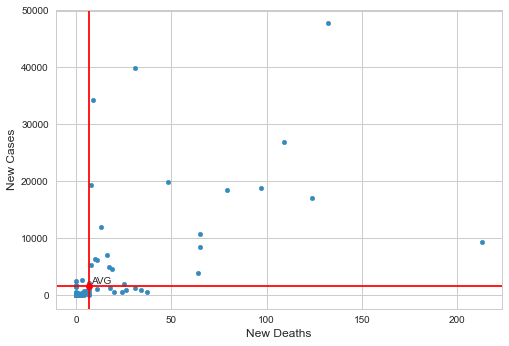

In [112]:
data_df.plot.scatter('New Deaths', 'New Cases')
x_mean, y_mean = data_df['New Deaths'].mean(), data_df['New Cases'].mean()
plt.plot(x_mean, y_mean, 'ro')
plt.axhline(y_mean, c='r')
plt.axvline(x_mean, c='r');
plt.text(x_mean + 1, y_mean + 5e2, 'AVG');

In [113]:
x_mean, y_mean

(6.561946902654867, 1574.1814159292035)

Nhận xét: đây là mối tương quan dương nhưng không mạnh. Thấy rằng lượng `New Deaths` lớn hơn trung bình khi `New Cases` đạt ít nhất khoảng 1000 ca; tuy nhiên, từ đồ thị ta thấy không phải cứ  `New Cases` > 1000 ca thì `New Deaths` trên trung bình. Tương tự, `New Cases` trên trung bình khi **đa số** `New Deaths` > 6.56

### Total Deaths ~ Total Recovered ~ Active Cases

Theo đường [link](https://www.worldometers.info/coronavirus/about/) này, `Total Cases` cấu tạo bởi 3 thành phần: `Active Cases`, `Total Deaths` & `Total Recovered`, ta sẽ dùng 100% stacked bar chart để xét tỉ trọng của 3 thành phần

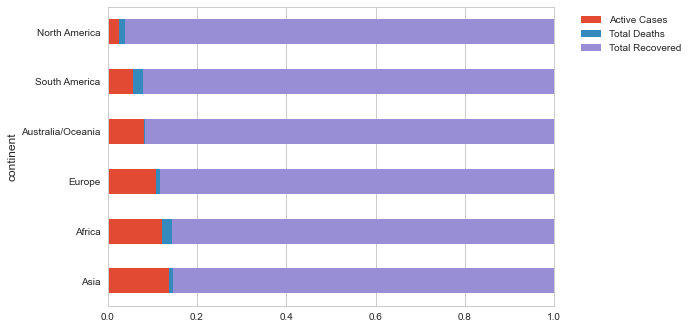

In [114]:
df = data_df.groupby('continent')[['Active Cases', 'Total Deaths', 'Total Recovered', 'Total Cases']].sum()
df['Active Cases'] = df['Active Cases'] / df['Total Cases']
df['Total Deaths'] = df['Total Deaths'] / df['Total Cases']
df['Total Recovered'] = df['Total Recovered'] / df['Total Cases']
df.drop(columns=['Total Cases'], inplace=True)
df.sort_values('Total Recovered').plot.barh(stacked=True);
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.xlim(0,1);

Nhận xét: `Total Recovered` chiếm tỉ trọng nhiều nhất trong 3 thành phần. Các châu lục được sắp xếp theo chiều giảm dần của `Total Recovered`, nhờ đó thấy rằng `Total Recovered` càng giảm thì `Active Cases` càng tăng

### Total Cases ~ Total Deaths ~ Total Recovered ~ Total Tests
Dùng biểu đồ **circular coordinates** có 4 góc (4 thuộc tính trên); với 5 polygon là 5 nước, lần lượt có `Population` thuộc [0, 20%], [20, 40%],...,[80, 100%]. Mục đích để kiểm tra giả thiết: "`Population` càng lớn thì thuộc tính x càng tăng"

- Đầu tiên, cần chọn ra nhóm các nước thuộc vào các khoảng phân vị [0, 20%], [20, 40%],..., [80, 100%] lần lượt tương ứng với các nhãn 5,4,3,2,1. Từ mỗi nhóm, ta lấy 1 nước đại diện, nước đại diện này có `Population` là trung vị trong nhóm đó. Cuối cùng ta thu dươc 5 nước đại diện cho 5 khoảng phân vị

In [115]:
df = data_df.copy()
df['quartile'] = pd.qcut(data_df['Population'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=[5,4,3,2,1])
cnt=0
def get_median_index(df, cnt=cnt):
    if cnt==0:
        cnt+=1 # tránh Vatican là 1 nước thiếu nhiều
        return df.sample(1, random_state=19)
    return df.loc[df['Population'] == df['Population'].median()]
df = df.groupby('quartile').apply(get_median_index).reset_index(drop=True)
df

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious,Total Tests,Population,continent,Density,quartile
0,Palau,4190.0,0.0,6.0,0.0,3803.0,0.0,381.0,0.0,42790.0,18249.0,Australia/Oceania,39.7233,5
1,Iceland,183974.0,0.0,110.0,0.0,75685.0,0.0,108179.0,1.0,1953616.0,345217.0,Europe,3.3533,4
2,Croatia,1113547.0,30.0,15742.0,7.0,1093859.0,822.0,3946.0,23.0,4743521.0,4059850.0,Europe,71.7264,3
3,Ecuador,866925.0,41.0,35528.0,0.0,852606.0,0.0,0.0,759.0,2470170.0,18123652.0,South America,65.4288,2
4,Japan,7374251.0,39899.0,29023.0,31.0,6829906.0,44328.0,515322.0,222.0,45700624.0,125781818.0,Asia,332.2966,1


- Các **circular coordinates chart** ứng với 5 châu được xếp theo thứ tự tăng dần Population từ trái qua phải, từ trên xuống dưới 

In [116]:
from plotly.subplots import make_subplots

nr, nc = 3,2
fig = make_subplots(rows=nr, cols=nc, specs=[[{'type': 'polar'}]*nc]*nr)
categories = 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Tests'
r, c = 1, 1

for i in range(df.shape[0]):
    fig.add_trace(go.Scatterpolar(r=df.iloc[i, [1, 3, 5, 9]].to_list(),
                                  theta=categories,
                                  fill='toself',
                                  name=df.iloc[i, 0]),
                  r, c)
    if c % nc == 0: 
        r += 1
        c=1
    else: c += 1
    
fig.update_layout(
    margin=dict(l=25, r=20, t=20, b=25),
    showlegend=True
)
fig.show()

- Trong trường hợp hình nhỏ khó thấy, Plotly cho phép ta tương tác trực tiếp để phóng to mỗi subplot bằng cách di chuột vào tâm, giữ và kéo ra ngoài rìa
- Nhận xét: 
    - `Total Population` ~ `Total Tests`: Dân số càng tăng, `Total Tests` cũng gần như tăng theo, trừ Ecuador dân đông nhưng `Total Tests` lại ít hơn Croatia
    - `Total Population` ~ `Total Cases`: Dân số càng tăng, số ca nhiễm cũng tăng theo, điều này tương đối dễ hiểu
    - `Total Recovered` lên xuống thất thường khi `Total Population` tăng, chứng tỏ còn nhiều yếu tố khác ảnh hưởng tới trường dữ liệu này

### Total Cases ~ (Active Cases, Total Deaths, Total Recovered)

Ta sẽ xét tổng số ca nhiễm `Total Cases` trên cả thế giới (World) từ trong 1 tuần, từ 18-25/4/2022, và xem cụ thể các trường `Active Cases`, `Total Deaths`, `Total Recovered` ảnh hưởng như thế nào tới tổng số ca nhiễm 1 tuần như công thức đã được đề cập ở link [này](https://www.worldometers.info/coronavirus/about/): '''**Active Cases = (total cases) - (total deaths) - (recovered)**'''
- Đầu tiên, ta lấy dữ liệu ngày 18 và 25 cùng các cột liên quan. Sau đó, tính sự chênh lệch (hiệu) của các cột `Active Cases`, `Total Deaths`, `Total Recovered` giữa ngày 18 và 25 để biết trong 1 tuần thì các trường dữ liệu này tăng/giảm ra sao. Cuối cùng, kết quả là 1 `df` như bên dưới

In [117]:
world_18 = data_df[['Total Cases', 'Active Cases', 'Total Deaths', 'Total Recovered']].sum()
df_25 = pd.read_csv(f'Worldometer-data-preprocessed/table_25-04-2022_preprocessed.csv')
world_25 = df_25[['Total Cases', 'Active Cases', 'Total Deaths', 'Total Recovered']].sum()

df = world_18[['Total Cases']]
df = pd.concat([df,
                world_25[['Active Cases']] - world_18[['Active Cases']],
                world_25[['Total Deaths']] - world_18[['Total Deaths']],
                world_25[['Total Recovered']] - world_18[['Total Recovered']]])
df = pd.DataFrame(df, columns=['amount'])
df = pd.concat([df, 
                pd.DataFrame({'amount': [df['amount'].sum()]}).rename(index={0: 'Total Cases (25/4)'})], 
               axis=0)
df.rename({'Total Cases':'Total Cases (18/4)'}, inplace=True)
df

,amount
Total Cases (18/4),505262739.0
Active Cases,-1852229.0
Total Deaths,19760.0
Total Recovered,6517117.0
Total Cases (25/4),509947387.0


- Vì sự thay đổi của từng thành phần (`Active Cases`, `Total Deaths`, `Total Recovered`) sẽ dẫn tới sự thay đổi của phần tổng thể (`Total Cases`), vì thế biểu đồ waterfall được sử dụng để nhấn mạnh vào sự thay đổi thành phần

In [118]:
text = df['amount'].apply(lambda x: str(x) if x < 0 else '+' + str(x))

fig = go.Figure(go.Waterfall(
    x = df.index,
    text=text, textposition = "outside",
    y = df['amount'][:-1].to_list() + [None],
    measure = [ "absolute","relative", "relative","relative", "total" ]   
))
fig.update_layout(
    yaxis_range=[4.95 * 1e8, 5.7 * 1e8],
    title='Total Cases progress', showlegend = True)

Nhận xét: `Total Cases` sau 1 tuần tăng, cụ thể sự tăng này là do `Active Cases` giảm, và 2 trường `Total Deaths` và `Total Recovered` tăng (với `Total Recovered` tăng mạnh)

- Coi kỹ từng quan hệ giữa các cặp thuộc tính ['Active Cases', 'Total Deaths', 'Total Recovered', 'Total Cases']


<Figure size 1080x720 with 0 Axes>

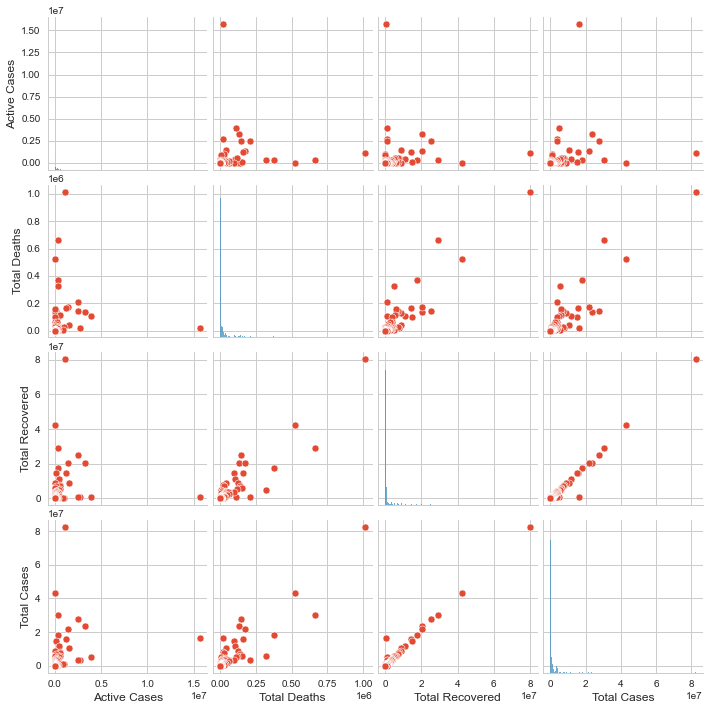

In [119]:
plt.figure(figsize=(15,10))
cols = ['Active Cases', 'Total Deaths', 'Total Recovered', 'Total Cases']
sns.pairplot(data_df[cols],kind='scatter')

Nhận xét: `Total Recovered` & `Total Cases` có quan hệ gần như tuyến tính. Cụ thể là nếu `Total Cases` tăng/giảm thì `Total Recovered` cũng tăng/giảm, ta sẽ thử chọn ngẫu nhiên mỗi 10 nước và xây dựng biểu đồ **group bar chart** để xem thử có đúng như vậy không

#### Total Cases ~ Total Recovered

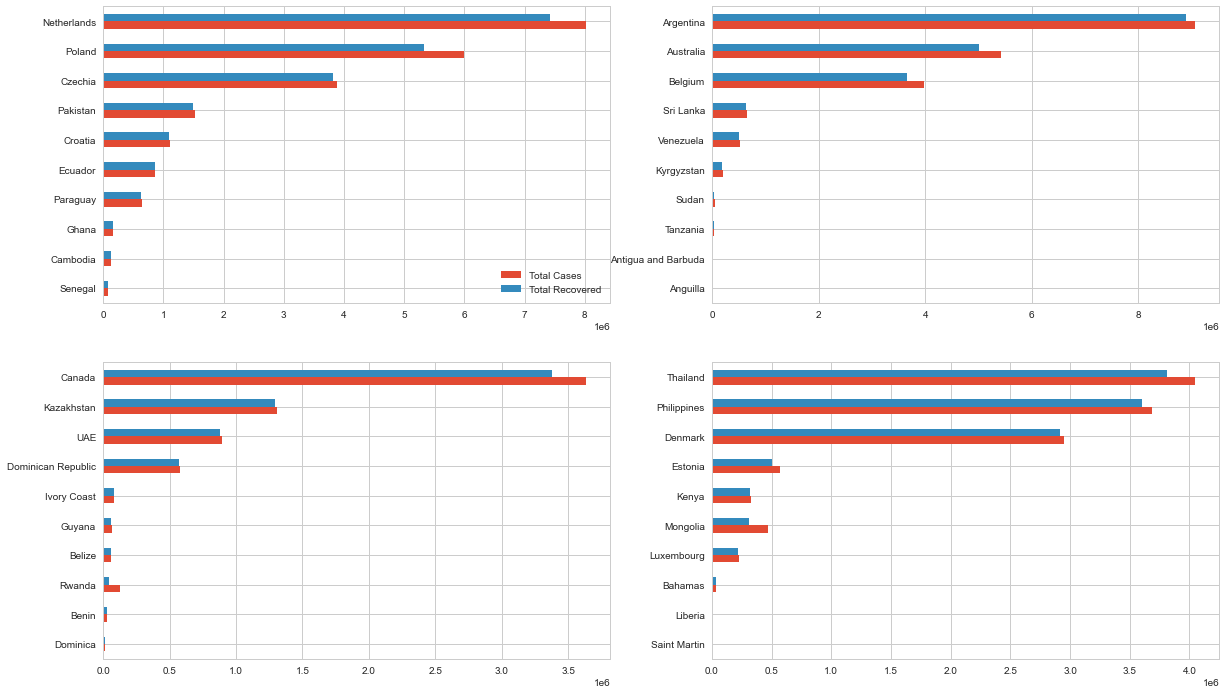

In [120]:
df = data_df[['Country', 'Total Cases', 'Total Recovered']].set_index('Country')

for i in range(4):  
    ax = plt.subplot(2,2,i+1)
    df_10 = df.sample(10, replace=False, random_state=23+i)
    df_10.sort_values('Total Recovered').plot.barh(ax=ax, figsize=(20,12), xlabel="")
    if i > 0: ax.get_legend().remove()
    else: plt.legend(loc='lower right')
    df = df[~df.index.isin(df_10.index)]

- Mối quan hệ tuyến tính được thể hiện tương đối đúng ở hầu hết các nước, trừ 1 số nước đặc biệt thì có `Total Cases` cao hơn 1 số nước nhưng `Total Recovered` lại thấp hơn (VD: Ukraine, Tunisia, ...)

#### Active Cases & Total Recovered

Với mỗi châu lục, ta muốn biết rằng liệu sự thay đổi `Active Cases` theo thời gian 1 tuần từ 18-25/4/2022 có liên quan tới sự thay đổi của trường dữ liệu `Total Recovered` hay không

In [121]:
df = week_df.groupby(['continent', 'day'])[['Active Cases', 'Total Recovered']].sum().reset_index()
df['day'] = df['day'].apply(lambda x: x[:5])
df = df.set_index('day')
df.head()

,continent,Active Cases,Total Recovered
day,,,
18-04,Africa,1451814.0,10176379.0
19-04,Africa,1453241.0,10177682.0
20-04,Africa,1455595.0,10192494.0
21-04,Africa,1458387.0,10195115.0
22-04,Africa,1461415.0,10197204.0


Ta kết hợp 2 loại biểu đồ: bar chart cho `Active Cases` & line chart cho `Total Recovered`. Lý do không dùng grouped bar chart với mỗi 2 cột cho 1 ngày là vì `Active Cases` & `Total Recovered` có giá trị cách nhau khá xa, vì dụ `Active Cases` có giá trị 1.46M trong khi `Total Recovered` lại có giá trị 10.175M, biểu đồ sẽ bị nén và khó nhìn ra xu hướng

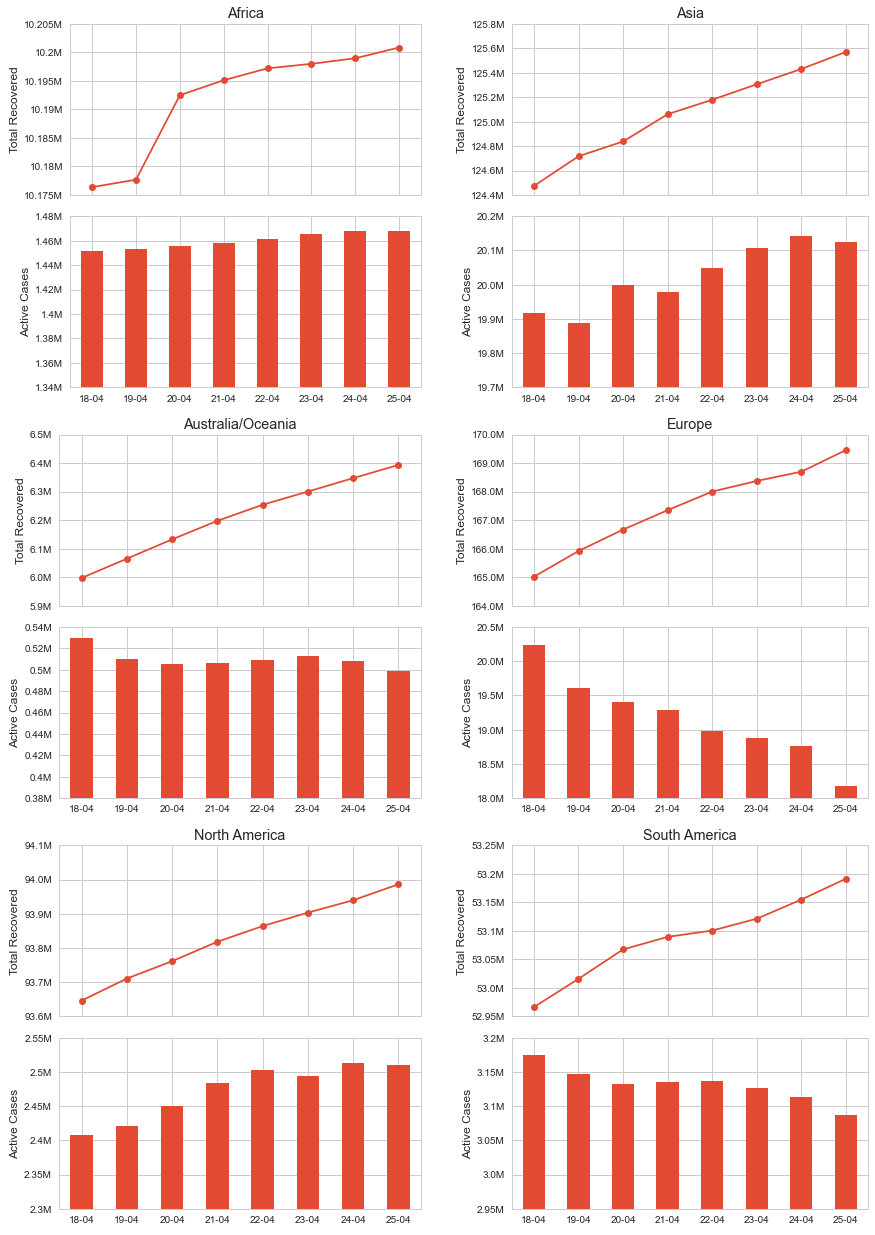

In [122]:
nr, nc = 2, 1 # nr, nc for 1 subfigure
fig = plt.figure(constrained_layout=True, figsize=(12, 17))
subfigs = fig.subfigures(3, 2, wspace=0.07) # 6 subfig

for subfig, continent in zip(subfigs.flat, df['continent'].unique()):
    # subfig.suptitle(f'{continent}')
    axs = subfig.subplots(nr, nc, sharex=True)
    
    df_cont = df[df['continent'] == continent].drop(columns=['continent'])
    
    df_cont['Total Recovered'].plot.line(marker='o', ax=axs[0], ylabel='Total Recovered', title=continent)
    yticks = axs[0].get_yticks()
    trunc_labels = [f'{round(y/1e6,3)}M' for y in yticks]
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels(trunc_labels)

    df_cont[['Active Cases']].plot.bar(ax=axs[1], legend='', rot=0, xlabel='', ylabel='Active Cases')
    axs[1].set_ylim(df_cont['Active Cases'].min() - 100000, df_cont['Active Cases'].max())
    yticks = axs[1].get_yticks()
    trunc_labels = [f'{round(y/1e6,3)}M' for y in yticks]
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels(trunc_labels);

Nhận xét: `Total Recovered` tăng qua từng ngày bất kể `Active Cases` có tăng hay giảm. Điều này có thể chứng tỏ không có mối quan hệ nào giữa 2 trường này. Ta thử kiểm chứng bằng biểu đồ scatter

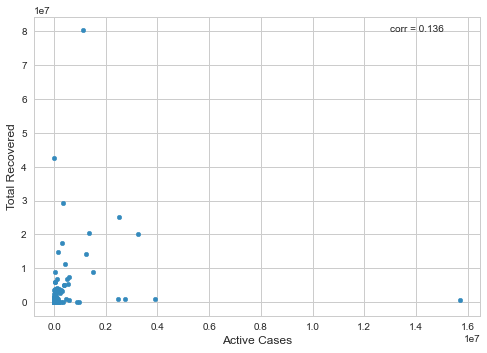

In [123]:
data_df.plot.scatter('Active Cases', 'Total Recovered')
corr = data_df['Active Cases'].corr(data_df['Total Recovered'])
plt.text(1.3 * 1e7, 8 * 1e7, 'corr = %0.3f' % corr);

Nhận xét: 2 trường này có tương quan dương nhưng mối quan hệ này lại rất yếu vì độ tương quan Pearson = 0.136

### New Deaths & các cột còn lại
Tìm mối liên hệ giữa `New Deaths` và các thuộc tính khác có trong `data_df`.<br>
Chúng ta chỉ xét trên châu lục **Europe**

In [124]:
df = week_df[week_df['continent'] == 'Europe'].groupby('day')[['New Cases', 'New Deaths', 'New Recovered', 'Active Cases', 'Serious']].sum()
df = df.reset_index()
df.head()

,day,New Cases,New Deaths,New Recovered,Active Cases,Serious
0,18-04-2022,120322.0,693.0,730283.0,20236336.0,9212.0
1,19-04-2022,267488.0,1137.0,891529.0,19607425.0,9203.0
2,20-04-2022,518969.0,1854.0,742427.0,19406118.0,9151.0
3,21-04-2022,479519.0,2056.0,661646.0,19280309.0,9236.0
4,22-04-2022,350697.0,1324.0,644939.0,18979043.0,9170.0


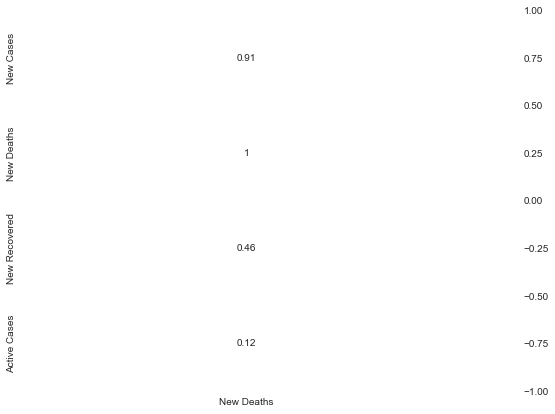

In [125]:
corrs = df[['New Cases', 'New Deaths', 'New Recovered', 'Active Cases']].corr()[['New Deaths']]

plt.figure(figsize=(10, 7))
sns.heatmap(data=corrs, cmap=ListedColormap(['white']), annot=True, vmax=1, vmin=-1);

Sử dụng biểu đồ heatmap vì biểu đồ này có thể giúp dễ dàng phân biệt sự quan trọng của dữ liệu bằng tone màu khác nhau.

Nhận xét: Ta thấy rằng `New Cases` và `New Deaths` có độ tương quan khá là cao. Xem xét dưới góc nhìn scatter plot để kiểm chứng điều này:

- Scatter plot

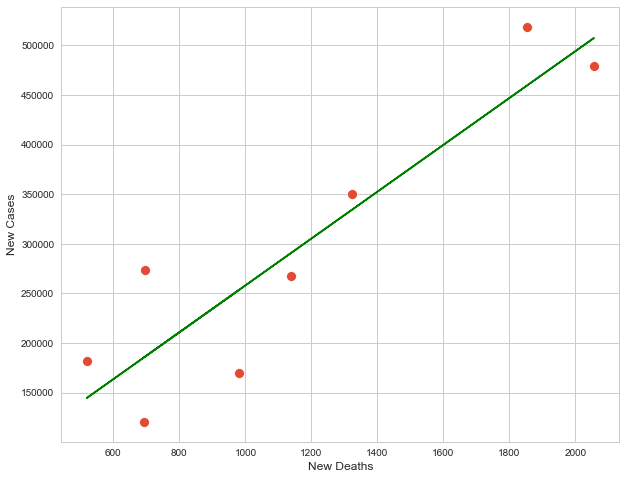

In [126]:
dc_df = df[['New Cases', 'New Deaths', 'day']]
plt.figure(figsize=(10, 8))
sns.scatterplot(x='New Deaths', y='New Cases', data=dc_df, legend=False, s=100);
x = dc_df['New Deaths'].values
y = dc_df['New Cases'].values

m, b = np.polyfit(x, y, 1)

plt.plot(x, x*m + b, c='green');

Sử dụng biểu đồ scatter vì nó có thể biểu diễn được quan hệ của 2 trường giá trị.<br>
Bên cạnh đó sử dụng thể 1 đường Regression để có thể biểu diên rõ hơn xu hướng của quan hệ của 2 trường giá trị.

Nhận xét: ta có thể thì số ca nhiễm mới càng tăng thì số ca tử vong mới cũng càng tăng, cho thấy giữa số ca nhiễm mới và số ca chết mới có quan hệ tuyến tính với nhau và quan hệ này được thể hiện rõ ràng qua việc đường Regression có thể fit gần khớp với các điểm dữ liệu.

### `New Cases` & `Density`
Tìm mối liên hệ giữa `Total Cases` và `Density`.<br>
Hypothesis là nếu Mật độ dân số càng cao thì có số ca nhiễm càng nhiều và ngược lại.

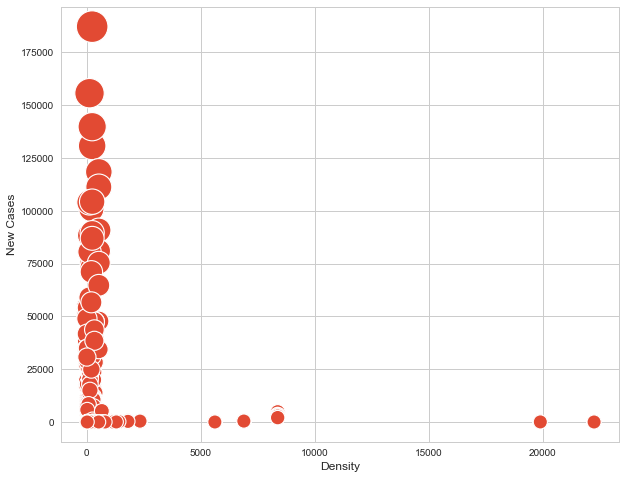

In [127]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=week_df, y='New Cases', x='Density', size='New Cases', legend=False, sizes=(200, 1000));

Sử dụng Bubble Chart vì biểu đồ này vừa có thể biểu diễn quên hệ giữa 2 trường dữ liệu và vừa có thể biểu hiện độ lớn của quan hệ đố qua kích cỡ của điểm dữ liệu.

Nhận xét: Nhìn vào biểu đồ thì chúng ta có thể dễ dàng thấy số ca nhiễm không có mối liên hệ nào với mật độ dân số.

## 3. Quan hệ nhân quả

- Xét tính tương quan của các cột bằng biểu đồ heatmap, do yêu cầu không dùng màu để hiểu thông tin nên heatmap bên dưới sẽ không có màu mà chỉ chứa giá trị Pearson correlation

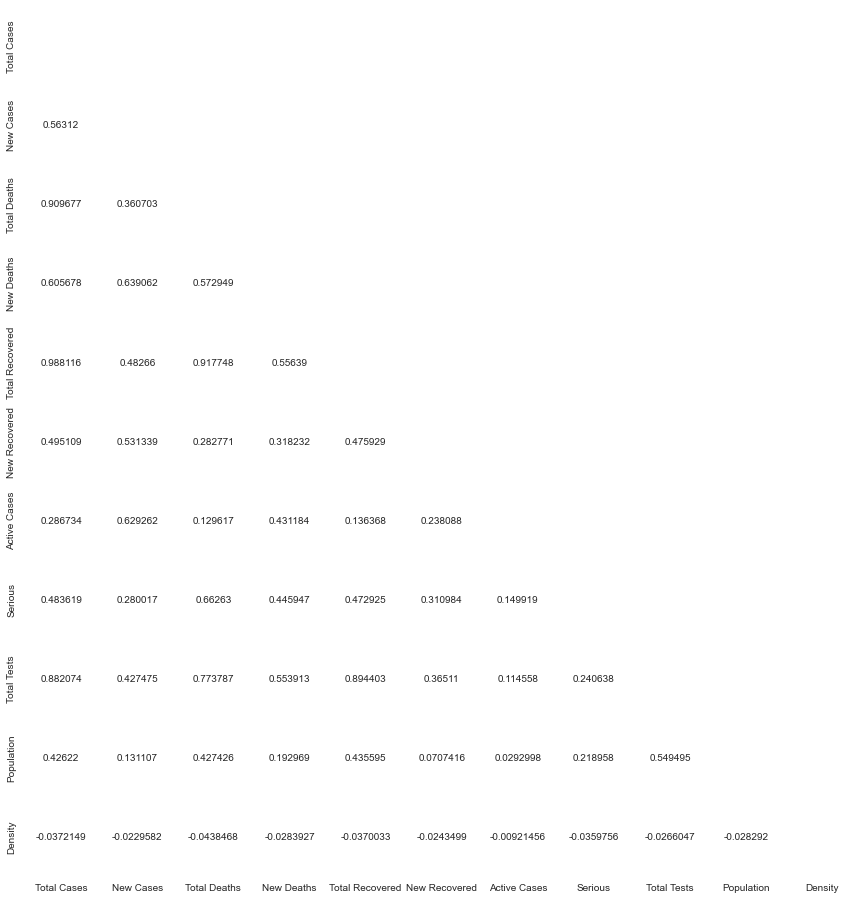

In [128]:
corr = data_df.corr()
matrix = np.triu(corr)

plt.subplots(figsize=(15,16))

with sns.axes_style('white'):
    sns.heatmap(corr, mask=matrix,
                cbar=False,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

Nhận xét: có thể thấy gần như các trường dữ liệu đều tỉ lệ thuận với nhau. Trường dữ liệu `Total Cases` ảnh hưởng rõ ràng nhất đối với các trường dữ liệu khác. Các cặp trường dữ liệu có ảnh hưởng lẫn nhau nổi bật nhất là: (`Total Cases`, `Total Tests`), (`Total Cases`, `Total Recovered`), (`Total Cases`, `Total Deaths`), (`Total Deaths`, `Total Recovered`), (`Total Recovered`, `Total Tests`)

### Khảo sát mối quan hệ nhân quả [`Total Recovered`, `Serious`] -> `Total Tests`

- Ta sẽ xây dựng mô hình hồi quy tuyến tính với các biến độc lập là các trường `Total Recovered`, `Serious` và biến phụ thuộc là `Total Tests`

In [129]:
X = data_df[['Total Recovered', 'Serious']].to_numpy()
y = data_df['Total Tests'].to_numpy()
reg = LinearRegression().fit(X, y)

- Để đơn giản thì thay vì xây dựng mặt phẳng 3D và vẽ mặt phẳng hồi quy tuyến tính thì ta sẽ so sánh giá trị thực tế và giá trị dự đoán trên hệ trục 2D như hình dưới, cũng như vẽ đường nét đứt thể hiện đường đúng (ground truth) và đường nét liền thể hiện kết quả dự đoán mô hình

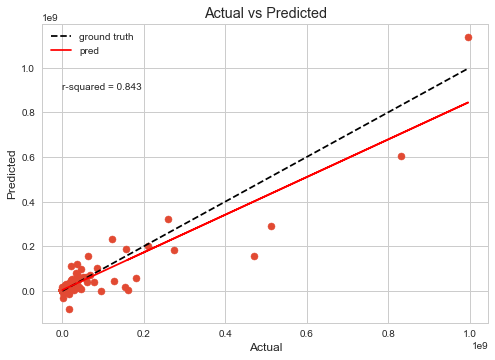

In [130]:
y_pred = reg.predict(X)
r_squared = r2_score(y, y_pred)

fig, ax = plt.subplots()
plt.scatter(y, y_pred)
line1, = ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='ground truth')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')
#regression line
y_test, y_predicted = y.reshape(-1,1), y_pred.reshape(-1,1)
line2, = ax.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test), color='r', label='pred')
ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 0.9*1e9));
ax.legend(handles=[line1, line2]);

Nhận xét: Đường hồi quy có thể xấp xỉ được đường ground truth (nét đứt) khi Actual `Total Test` < 0.4, khi `Total Test` $>=$ 0.4 thì đường hồi quy có xu hướng bị ảnh hưởng bởi các điểm ngoại lai. Ngoài ra, giá trị r-squared=0.843, điều này chứng tỏ 2 biến `Total Recovered`, `Serious` giải thích được 84.3% dữ liệu. Vậy `Total Recovered`, `Serious` là 2 nguyên nhân chính trong nhiều nguyên nhân gây ra ảnh hưởng lên trường `Total Tests`

### Khảo sát mối quan hệ nhân quả giữa 2 cột (`Total Cases`, `Total Recovered`)

- Theo nguồn [này](https://www.itl.nist.gov/div898/handbook/ppc/section1/ppc136.htm#:~:text=Causality,observed%20behavior%20in%20the%20other): "**There is a causal relationship between two variables if a change in the level of one variable causes a change in the other variable**" $\to$ Ta sẽ kiểm tra mối quan hệ này trong nhiều ngày liền để coi thử mối tương quan tuyến tính có còn giữ được sự tuyến tính của nó trong nhiều ngày không

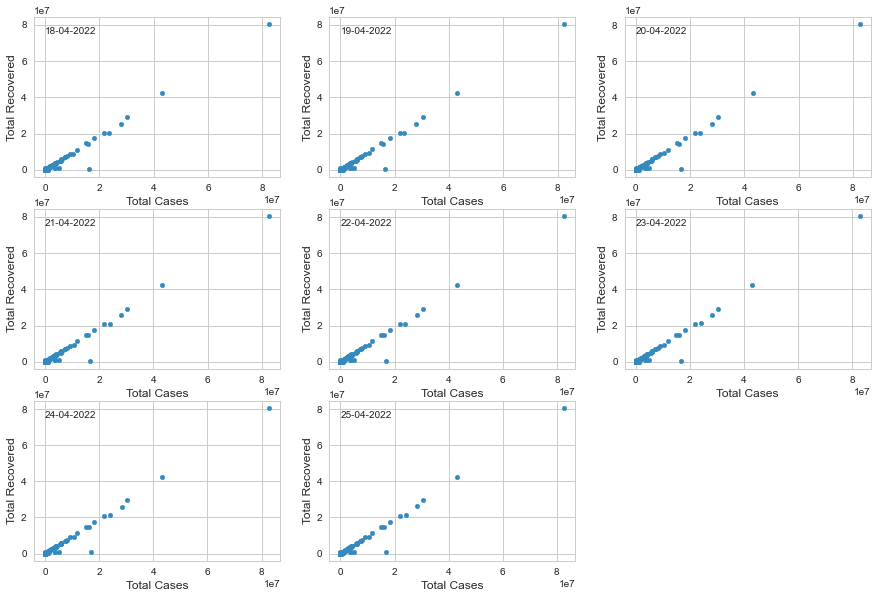

In [131]:
l, r = datetime.strptime('18-04-2022', '%d-%m-%Y'), datetime.strptime('25-04-2022', '%d-%m-%Y')
lst = [file for file in os.listdir('Worldometer-data') if 
       datetime.strptime(file.split('_')[1], '%d-%m-%Y') >= l and
       datetime.strptime(file.split('_')[1], '%d-%m-%Y') <= r]
nc = 3
nr = int(np.ceil(len(lst) / nc))
plt.figure(figsize=(15, 10))

for i, file in enumerate(lst, 1):
    ax = plt.subplot(nr, nc, i)
    d = file.split('_')[1]
    df = pd.read_csv(f'./Worldometer-data-preprocessed/table_{d}_preprocessed.csv')
    df.plot.scatter(x = 'Total Cases', y='Total Recovered', ax=ax)
    ax.text(0, 7.5*1e7, d)

Nhận xét: qua nhiều ngày, mối tương quan tuyến tính vẫn được giữ nguyên. Tiếp theo, ta muốn biết khi `Total Cases` tăng 1 đơn vị thì `Total Recovered` tăng/giảm thế nào $\to$ Sử dụng mô hình hồi quy tuyến tính với biến phụ thuộc là `Total Recovered` và biến độc lập là `Total Cases` 

In [132]:
X = data_df['Total Cases'].to_numpy().reshape(-1,1)
y = data_df['Total Recovered'].to_numpy()
reg = LinearRegression().fit(X, y)
reg.intercept_, reg.coef_ 

(-108094.24316907744, array([0.94348789]))

$\to$ Như vậy nếu coi `Total Recovered` là biến phụ thuộc và `Total Cases` là biến độc lập thì mối quan hệ giữa chúng được biểu diễn theo đường thẳng:
            
            Total Recovered = -108094.24316907744 + 0.94348789*Total Cases

- Ta sẽ vẽ đường hồi quy lên dữ liệu và tính giá trị r-squared

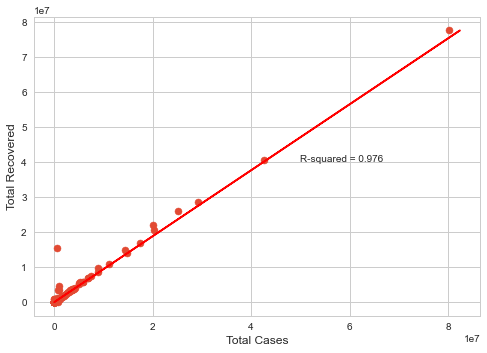

In [133]:
y_pred = reg.predict(X)
r_squared = r2_score(y, y_pred)

plt.scatter(y, y_pred)
plt.plot(X, y_pred, color='red')
plt.gca().set_xlabel('Total Cases')
plt.gca().set_ylabel('Total Recovered')
plt.text(5 * 1e7, 4 * 1e7, 'R-squared = %0.3f' % r_squared);

$\to$ Mô hình giải thích được 97.6% dữ liệu, chứng tỏ biến `Total Cases` giải thích được **phần lớn** xu hướng của biến `Total Recovered`. Ta có thể tự tin nói rằng `Total Cases` là nguyên nhân chính gây ra `Total Recovered`

### Khảo sát mối quan hệ nhân quả giữa `New Deaths` & `New Cases`

- Xét dữ liệu từ ngày 18-30/4/2022

In [134]:
df_world_time = pd.DataFrame()

# tổng hợp và lưu tình hình số liệu cả thế iowis qua thời gian
  # từ ngày 18 đến ngày 28
for d in range(18, 30, 1):
    day = f'{d}-04-2022'
    df_temp = pd.read_csv(f'./Worldometer-data/table_{day}_raw.csv').drop(columns='Unnamed: 0')

    df = df_temp[df_temp['Country, Other'] == 'World']
    df['day'] = day
    df_world_time = pd.concat([df_world_time, df], axis=0)

# Chỉ lưu những cột cần thiết
df_world_time = df_world_time[['Total Cases', 'New Cases', 'Total Deaths',
       'New Deaths', 'Total Recovered', 'New Recovered', 'Active Cases',
       'Serious, Critical','day']]
#Tiền xử lý các cột numeric
df_world_time[['New Cases', 'New Deaths', 'New Recovered']] = df_world_time[['New Cases', 'New Deaths', 'New Recovered']].applymap( \
                                              lambda x: x if x != x else float(x[1:].replace(',', '')))

cols = list(df_world_time)
num_cols = list(set(cols).difference(set(['New Cases', 'New Deaths', 'New Recovered', 'Country','day'])))
df_world_time[num_cols] = df_world_time[num_cols].applymap(lambda x: x if x != x else float(x.replace(',', '')))
df_world_time['day'] = pd.to_datetime(df_world_time['day'])
df_world_time.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_9588/1722342087.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",day
0,505263460.0,355765.0,6225557.0,1483.0,456606790.0,1014825.0,42431113.0,42014.0,2022-04-18
0,505899236.0,609820.0,6228605.0,2461.0,457920830.0,1314122.0,41749801.0,41934.0,2022-04-19
0,506882550.0,918218.0,6232833.0,3324.0,458967501.0,1041435.0,41682216.0,41786.0,2022-04-20
0,507828679.0,854280.0,6237649.0,3513.0,460009625.0,1017074.0,41581405.0,41814.0,2022-04-21
0,508509728.0,681049.0,6240200.0,2551.0,460886526.0,876901.0,41383002.0,41727.0,2022-04-22


C:\Users\Admin\AppData\Local\Temp/ipykernel_9588/3195719696.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



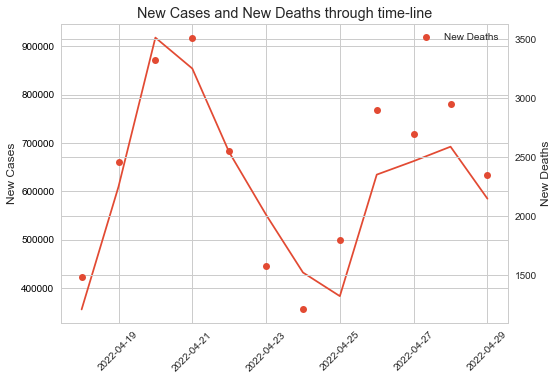

In [135]:
fig, ax1 = plt.subplots() 
  
# Vẽ biểu đồ có 2 trục tung để thế hiện 2 giá trị khác nhau
plt.title('New Cases and New Deaths through time-line')
ax1.set_ylabel('New Cases') 
plot_1 = ax1.plot(df_world_time['day'], df_world_time['New Cases'])
ax1.tick_params(axis ='y', labelcolor = 'black') 
ax1.set_xticklabels(df_world_time['day'],rotation=45)
#vẽ trục tung thứ 2
ax2 = ax1.twinx() 

ax2.set_ylabel('New Deaths') 
plot_2 = ax2.plot(df_world_time['day'],df_world_time['New Deaths'],'o',label = 'New Deaths')

plt.legend()
plt.show()

Chọn loại biểu đồ đường này bởi vì nó thể hiện tốt sự thay đổi của các giá trị theo thời gian. 

Có thể thấy dường như số ca nhiễm mới tăng thì số ca tử vong cũng tăng, còn những ngày số ca nhiễm mới giảm thì số ca tử vong cũng giảm theo, đây là nhìn chung số liệu của thế giới, vậy còn với các nước thì sao?

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Scatter plot show values of both New Deaths and New Cases every country in a week'}, xlabel='New Cases', ylabel='New Deaths'>

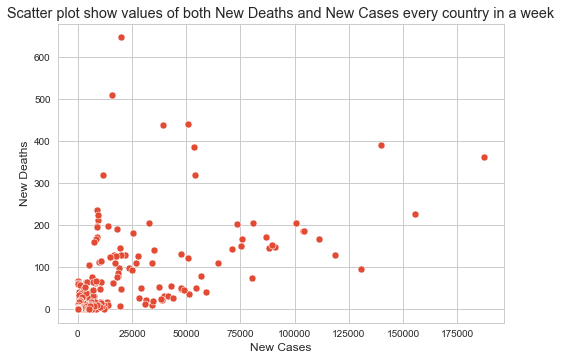

In [136]:
plt.title('Scatter plot show values of both New Deaths and New Cases every country in a week')
sns.scatterplot(week_df['New Cases'],week_df['New Deaths'])


Chọn biểu đồ scatter vì đây là biểu đồ tốt và đơn giản nhất để có thể thể hiện được mối quan hệ giữa 2 trường giá trị. Có thể lấy số liệu của 1 ngày để vẽ nhưng để có thể có cái nhìn rộng hơn, thì ta sẽ lấy số liệu của cả 1 tuần để có thể thể hiện rõ ràng hơn mối quan hệ của 2 trường dữ liệu

Khi nhìn vào tương quan giữa ca nhiễm mới và ca tử vong mới của các nước trong vòng 1 tuần thì có vẻ như là số ca nhiếm mới càng cao thì số ca tử vong mơi cũng có xu hướng tăng, nhưng khong phải là chính xác hoàn toàn, vậy còn yếu tố nào ảnh hưởng đến số ca tử vong mới?

C:\Users\Admin\AppData\Local\Temp/ipykernel_9588/2760250113.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



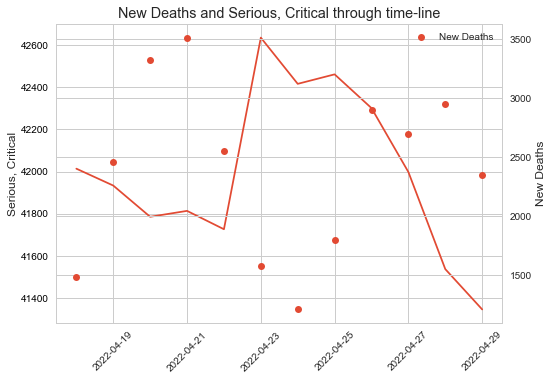

In [137]:
fig, ax1 = plt.subplots() 
  
plt.title('New Deaths and Serious, Critical through time-line')
ax1.set_ylabel('Serious, Critical') 
plot_1 = ax1.plot(df_world_time['day'], df_world_time['Serious, Critical'],label ='Serious, Critical')
ax1.tick_params(axis ='y', labelcolor = 'black') 
ax1.set_xticklabels(df_world_time['day'],rotation=45)

ax2 = ax1.twinx() 

  
ax2.set_ylabel('New Deaths') 
plot_2 = ax2.plot(df_world_time['day'],df_world_time['New Deaths'],'o',label = 'New Deaths')

plt.legend()
plt.show()

Tương tự biểu đồ trên, biểu đồ đường thể hiện tốt sự thay đổi của các giá trị theo thời gian.

Nhìn có vẻ như là New Deaths diễn biến chậm hơn Serious, Critical vài ngày. Có thể đúng bởi vì một người trong giai đoạn nguy hiểm chưa thể tử vong ngay được. Nhưng số liệu chưa đủ để có thể cho cái nhìn chính xác hơn 

Tạo cột TotalDeaths/TotalCases để có thể nhìn chung được tỉ lệ tử vong của các nước, qua đó một phần nào có thể đánh giá chất lượng y tế của các nước

In [138]:
data_df_temp = data_df.copy()
data_df_temp['TotalDeaths/TotalCases'] = data_df_temp['Total Deaths'] / data_df_temp['Total Cases'] 
data_df_temp['Predict New Deaths'] = data_df_temp['TotalDeaths/TotalCases'] * data_df_temp['New Cases']
data_df_temp.head()


,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious,Total Tests,Population,continent,Density,TotalDeaths/TotalCases,Predict New Deaths
0,China,185035.0,2742.0,4641.0,3.0,151407.0,1637.0,28987.0,71.0,160000000.0,1.439324e+09,Asia,149.2199,0.025082,68.774135
1,USA,82383494.0,26881.0,1015821.0,109.0,80244093.0,41383.0,1123580.0,1438.0,996639125.0,3.344853e+08,North America,36.0000,0.012330,331.453341
2,India,43045527.0,1247.0,521996.0,31.0,42511701.0,928.0,11830.0,698.0,832104846.0,1.404347e+09,Asia,427.8611,0.012127,15.121873
3,Brazil,30261088.0,8470.0,662076.0,65.0,29262483.0,35432.0,336529.0,8318.0,63776166.0,2.152705e+08,South America,25.2888,0.021879,185.313354
4,France,27790834.0,19810.0,144205.0,48.0,25132351.0,217445.0,2514278.0,1541.0,260504402.0,6.553266e+07,Europe,118.8782,0.005189,102.792923


C:\Users\Admin\AppData\Local\Temp/ipykernel_9588/1879590664.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



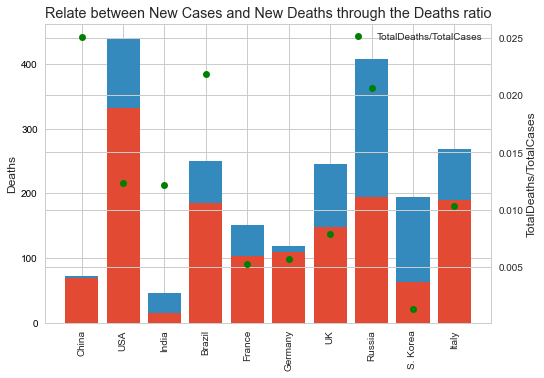

In [139]:
data_df_temp_1 = data_df_temp.head(10)

# Vẽ biểu đồ cột chồng giữa Predict New Deaths và New Deaths
fig, ax1 = plt.subplots() 
plt.title('Relate between New Cases and New Deaths through the Deaths ratio')
ax1.set_ylabel('Deaths') 
plot_1 = ax1.bar(data_df_temp_1['Country'],data_df_temp_1['Predict New Deaths'],label ='Predict New Deaths')
plot_2 = ax1.bar(data_df_temp_1['Country'],data_df_temp_1['New Deaths'],bottom= data_df_temp_1['Predict New Deaths'],label ='New Deaths')
ax1.tick_params(axis ='y', labelcolor = 'black') 
ax1.set_xticklabels(data_df_temp_1['Country'],rotation=90)
# Vẽ biểu đồ đường đẻ thể hiện tỉ lệ tử vong trung bình của các nước
ax2 = ax1.twinx() 
ax2.set_ylabel('TotalDeaths/TotalCases') 
plot_2 = ax2.plot(data_df_temp_1['Country'],data_df_temp_1['TotalDeaths/TotalCases'],'go',label = 'TotalDeaths/TotalCases')
plt.legend()
plt.show()

Chọn biểu đồ cột vì nó thể hiện rõ được số liệu của các đối tượng riêng biệt. Sử dụng biểu đồ cột chồng để có thể thể hiện rõ được chênh lệch giữa số liệu thực và số liệu sự đoán. Dùng biểu đồ đường để có thể chỉ rõ thêm tỉ lệ tử vong.

Không thể thông qua tỉ lệ tử vong của các nước mà dự đoán số người tử vong theo ca mắc mới được, có thể do mỗi giai đoạn thì số ca nhiễm và tỉ lệ tử vong khác nhau, tùy chủng loại virus, số lượng Vaccine đã tiêm mà cho lại kết quả khác nhau theo thời gian dẫn đến sử dụng giá trị trung bình để tính không được chính xác.

=> Kết luận: New Cases không phải là nguyên nhân chính dẫn đến New Deaths vì khi New Cases thay đổi thì New Deaths có thể không bị thay đổi theo. Mà New Deaths có thê chịu ảnh hưởng từ nhiều yếu tố khác như Serius Cases, chủng loại virus, số vaccine đã tiêm, số người mắc bệnh nền,… nên 2 trường dữ liệu này không có quan hệ nhân quả